In [1]:
%matplotlib inline

In [3]:
from MakeModels import *
encoder = makeEncoder()
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

NameError: name 'autoencodern' is not defined

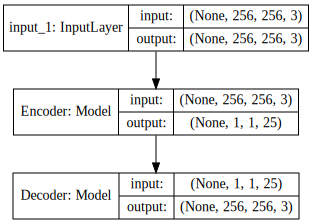

In [4]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(autoencoder,show_shapes=True).create(prog='dot', format='svg')))

Found 52850 images belonging to 1 classes.
Found 22650 images belonging to 1 classes.
(32, 256, 256, 3)


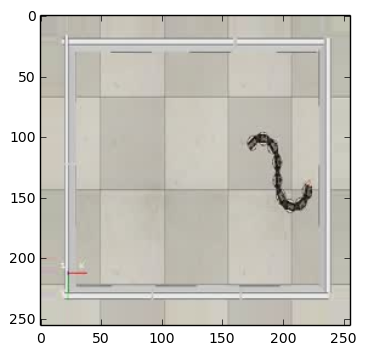

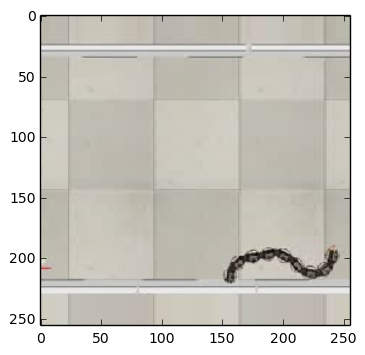

In [5]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/Training'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/Validation'

train_generator = train_datagen.flow_from_directory(
        trainPath,
        target_size=(imDim, imDim), shuffle=True,
        batch_size=batchSz)

validation_generator = val_datagen.flow_from_directory(
        valPath,
        target_size=(imDim, imDim),
        batch_size=batchSz)

X_batch,y_batch = train_generator.next()
# X_batch = X_batch.transpose(0,2,3,1)
print X_batch.shape
plt.figure()
plt.imshow(X_batch[0,:])
plt.figure()
plt.imshow(X_batch[3,:])

# model.fit_generator(
#         train_generator,
#         samples_per_epoch=2000,
#         nb_epoch=50,
#         validation_data=validation_generator,
#         nb_val_samples=800)

In [6]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb


numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 100

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

def trainGenerator():
    files = os.listdir(trainPath)
    files = files[:numBatchesPerEpoch*batchSz]
    while True:
        res = np.zeros(shape=(batchSz,imDim,imDim,3))
        for i in range(numBatchesPerEpoch):
            for j in range(batchSz):
                res[j,:] = plt.imread(trainPath+files[i*batchSz+j]).astype('float32')/255.0
            yield (res,res)
        
def valGenerator():  
    files = os.listdir(valPath)
    files = files[:nValBatches*batchSz]
    res = np.zeros(shape=(batchSz,imDim,imDim,3))
    while True:
        for i in range(nValBatches):
            for j in range(batchSz):
                res[j,:] = plt.imread(valPath+files[i*batchSz+j]).astype('float32')/255.0
            yield (res,res)

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


lr = 0.1
print "Learning rate=" + str(lr)
print "Compiling model"
autoencoder.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = autoencoder.fit_generator(generator=trainGenerator(),
                                    samples_per_epoch=numBatchesPerEpoch*batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=valGenerator(),
                                    nb_val_samples=nValBatches*batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/Model.h5'),
                                               ReduceLROnPlateau(factor=0.2,patience=2)]
                                   )

(32, 256, 256, 3)


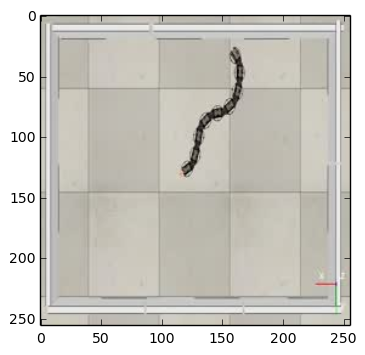

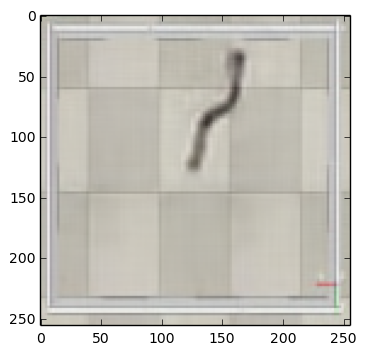

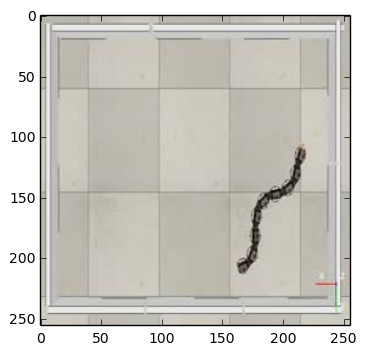

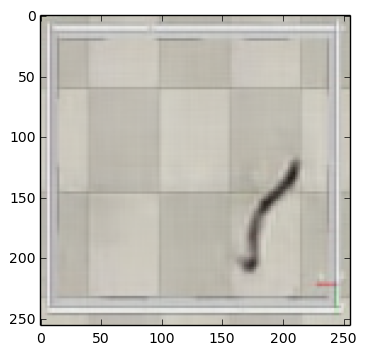

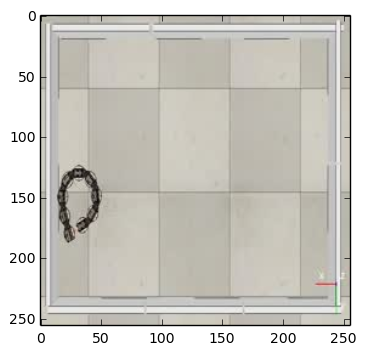

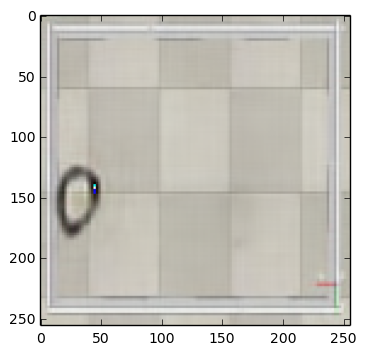

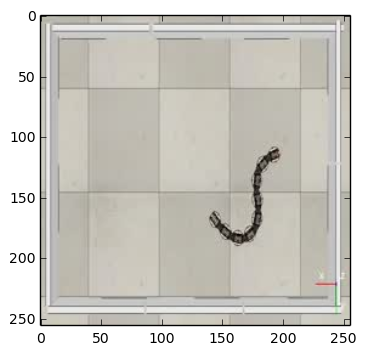

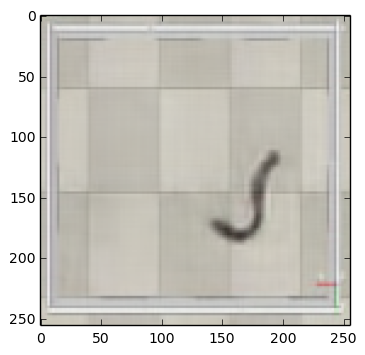

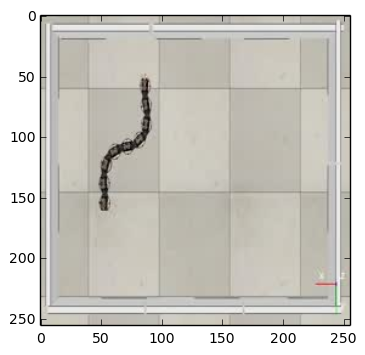

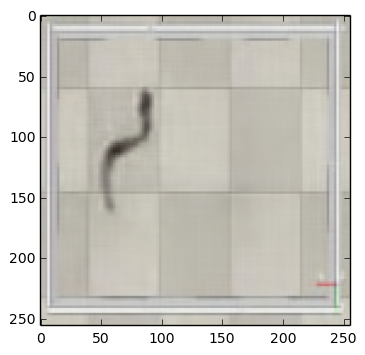

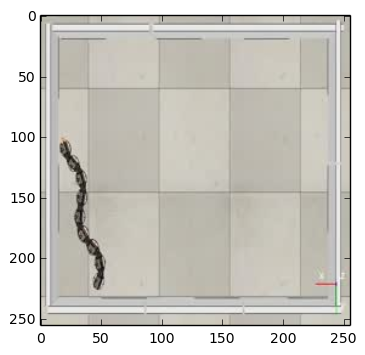

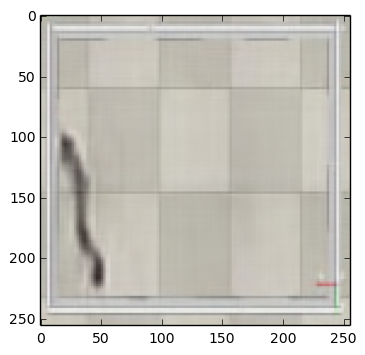

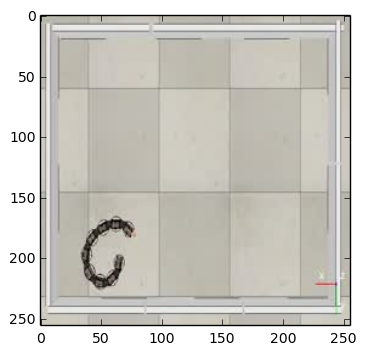

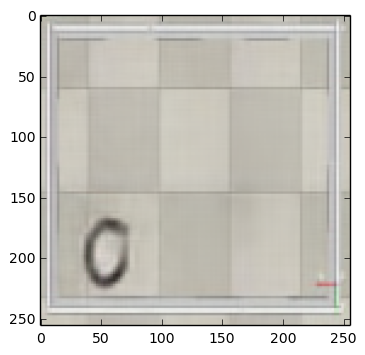

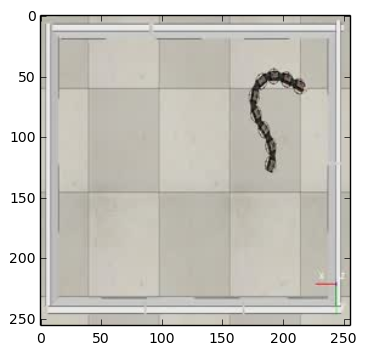

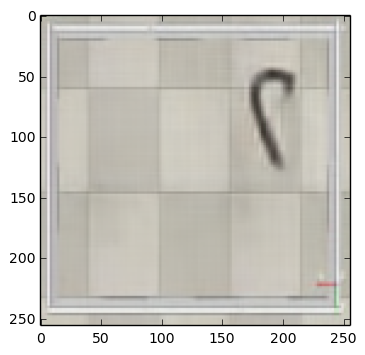

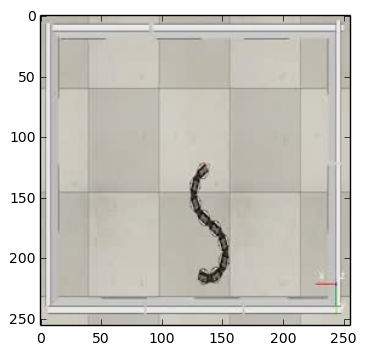

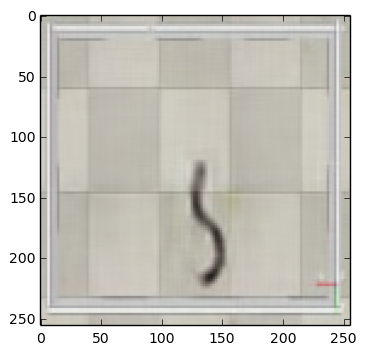

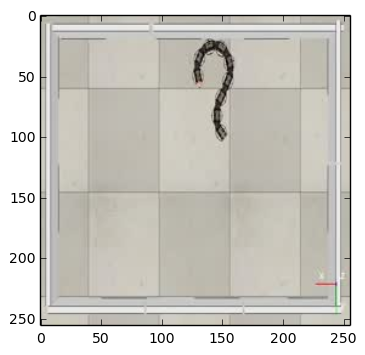

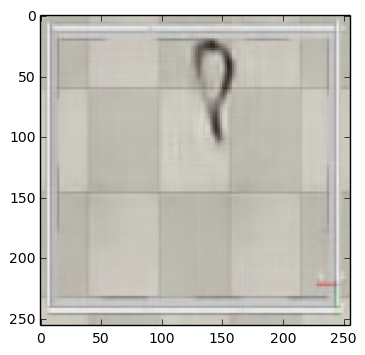

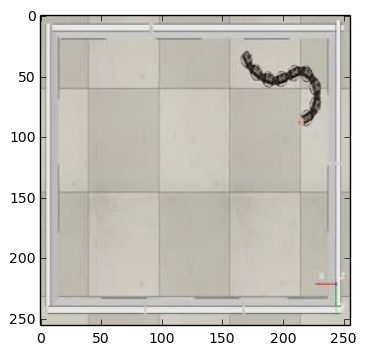

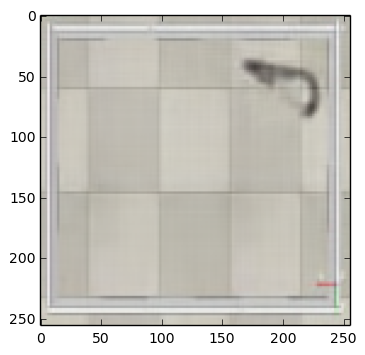

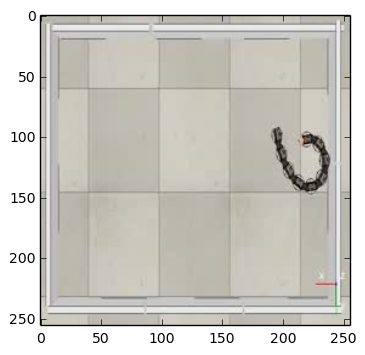

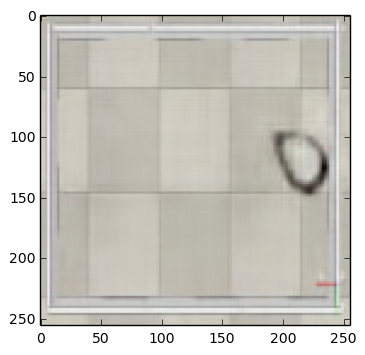

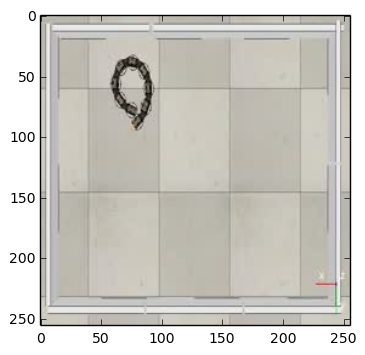

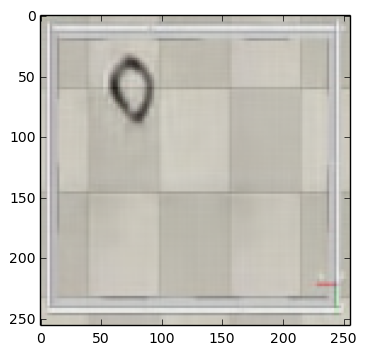

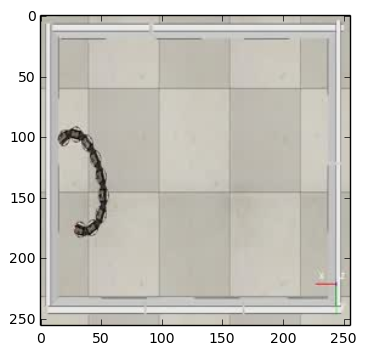

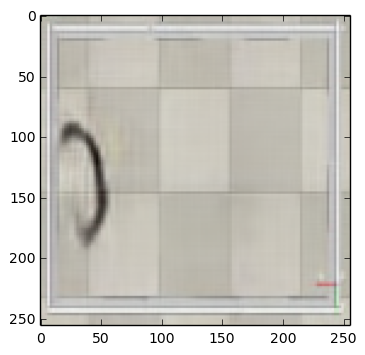

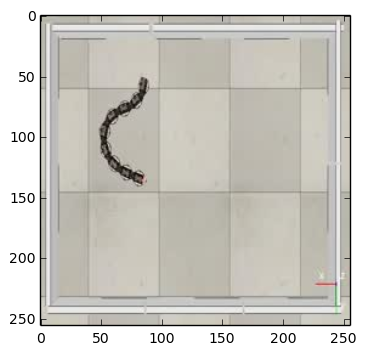

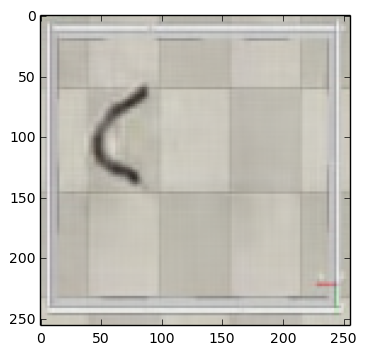

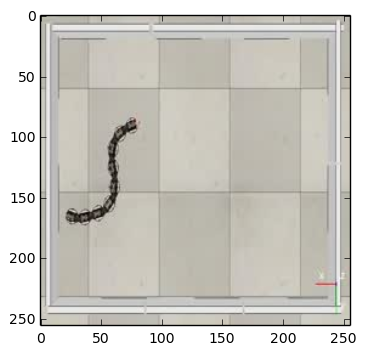

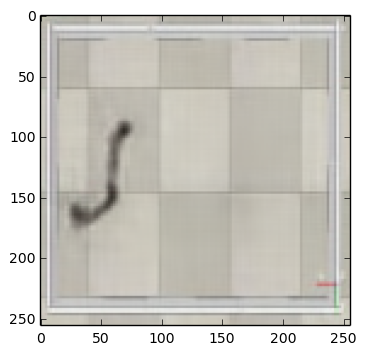

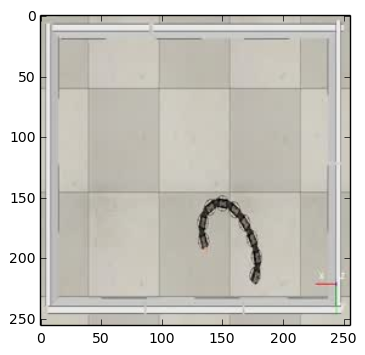

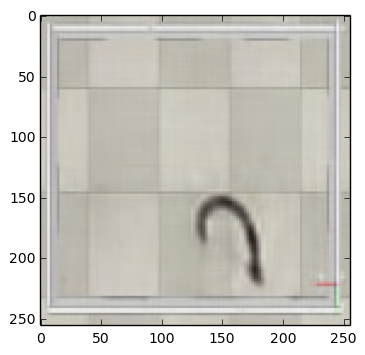

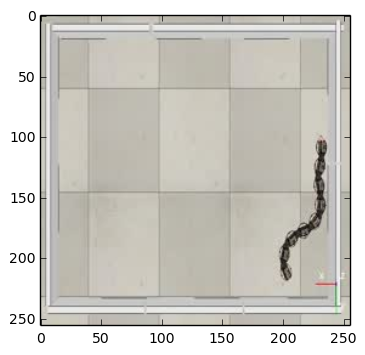

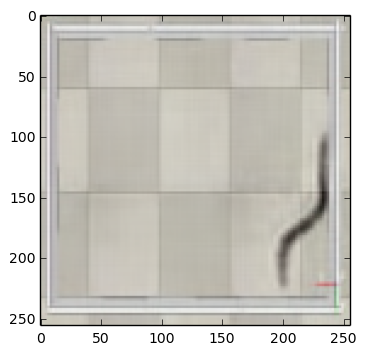

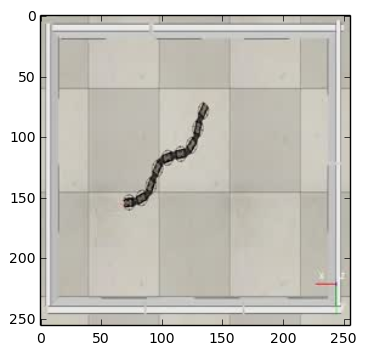

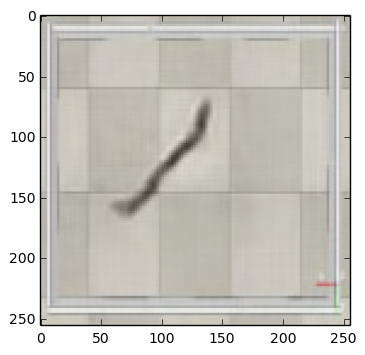

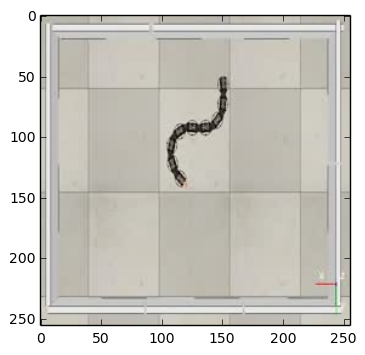

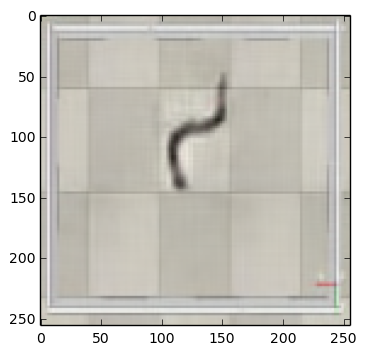

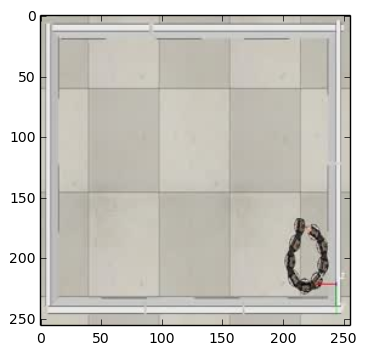

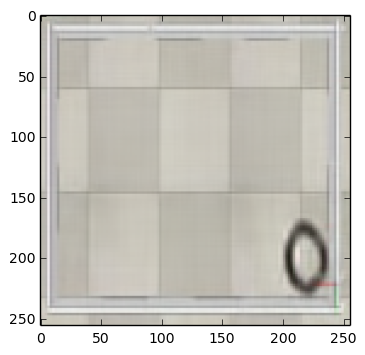

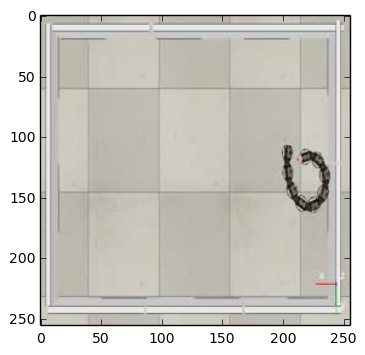

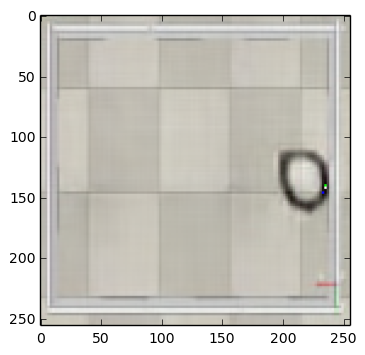

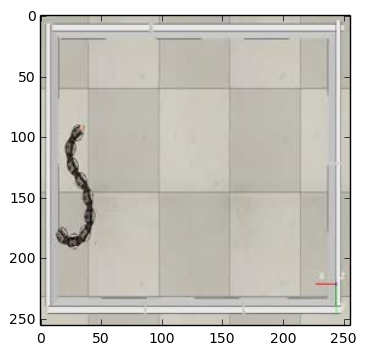

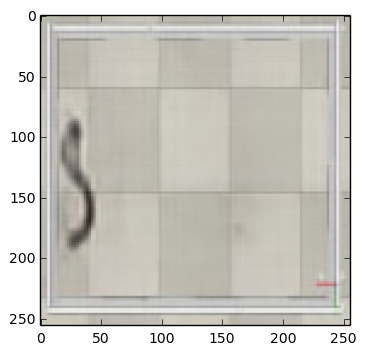

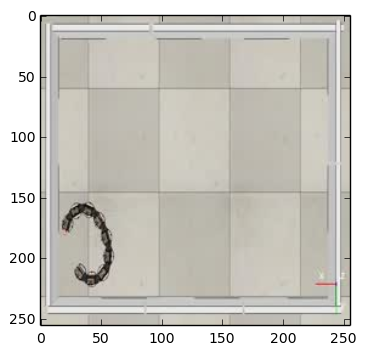

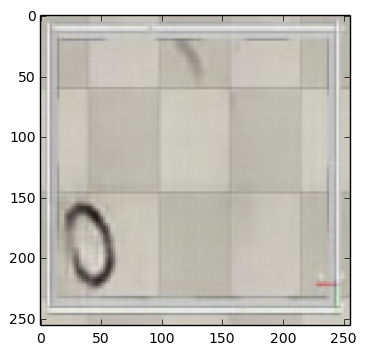

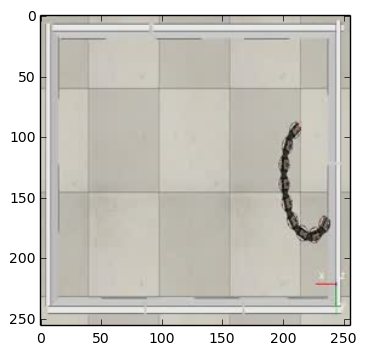

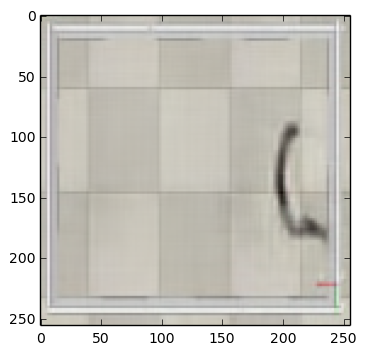

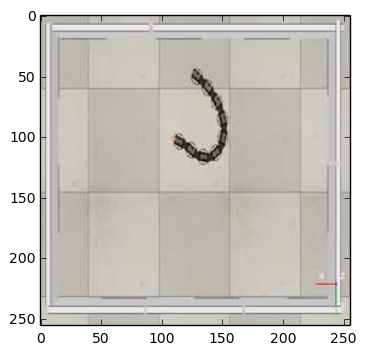

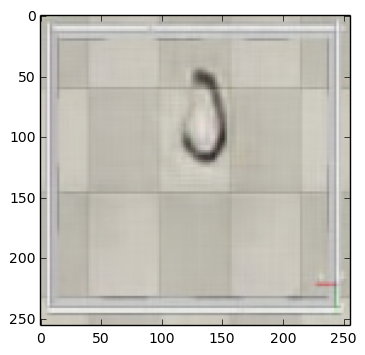

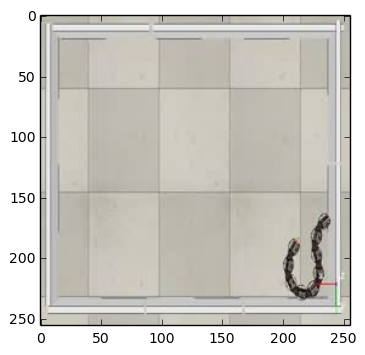

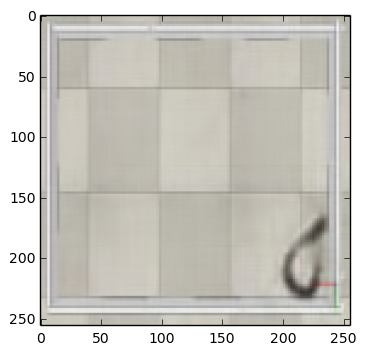

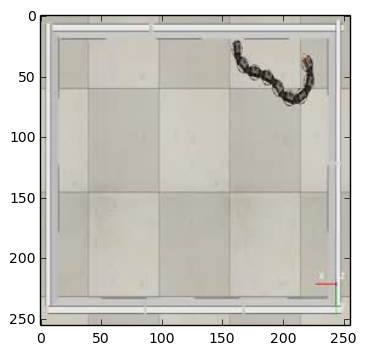

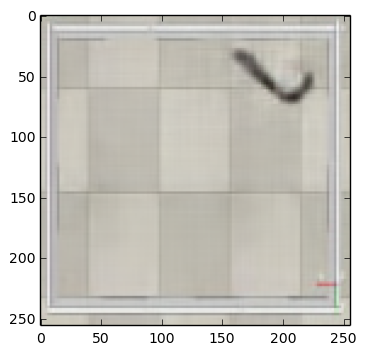

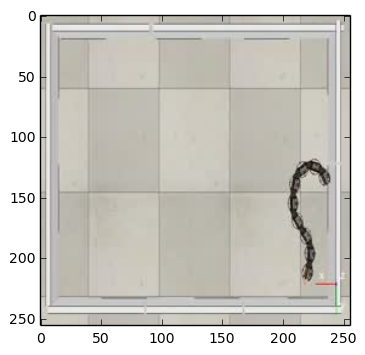

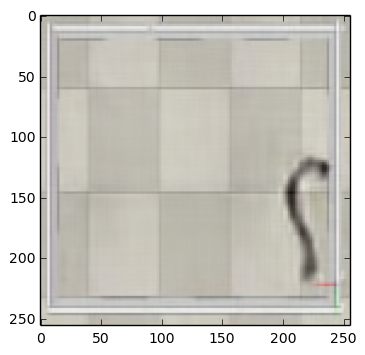

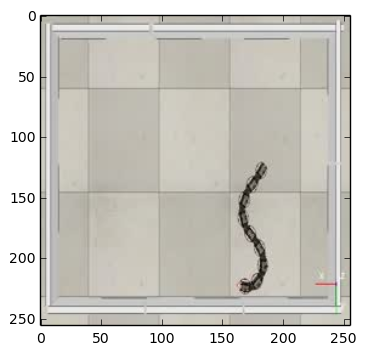

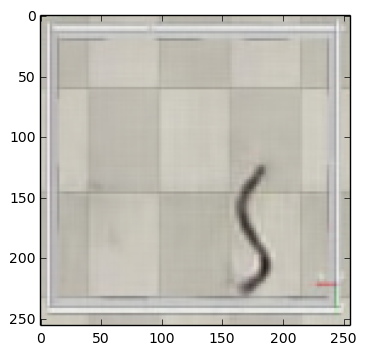

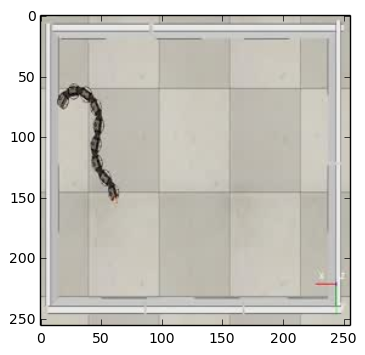

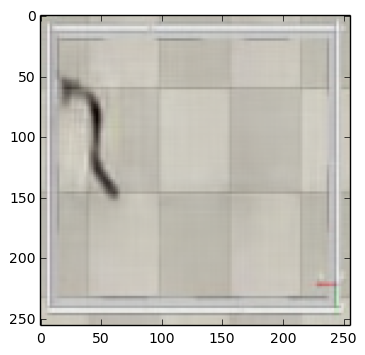

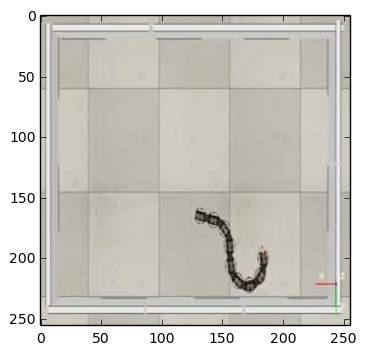

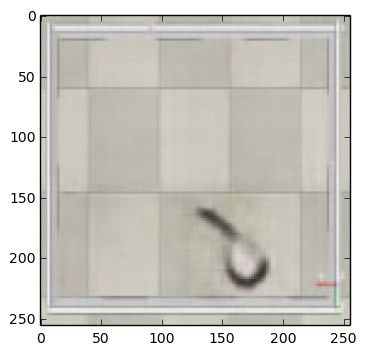

In [9]:
autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)
im_in = validation_generator.next()
im_in = im_in[0]
im_out = autoencoder.predict_on_batch(im_in)
print im_out.shape

for i in range(batchSz):
    plt.figure()
    plt.imshow(im_in[i,:])
    plt.figure()
    plt.imshow(im_out[i,:])

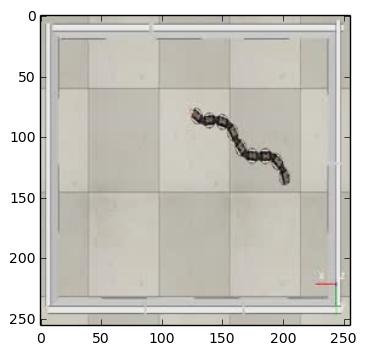

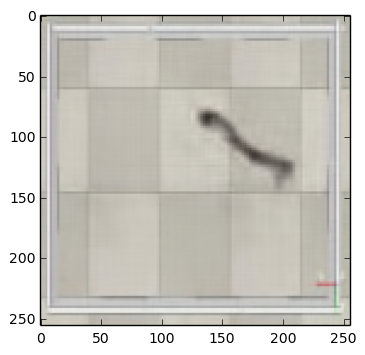

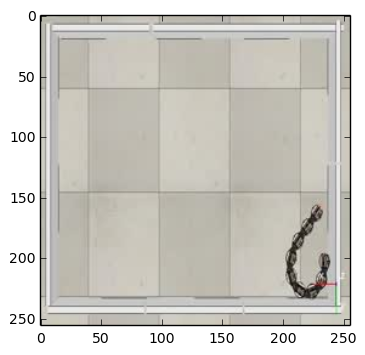

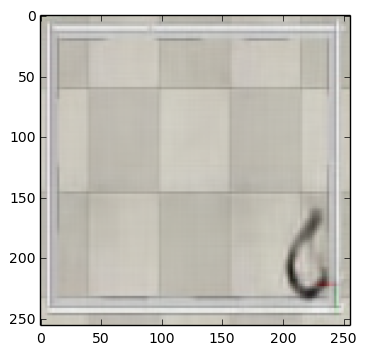

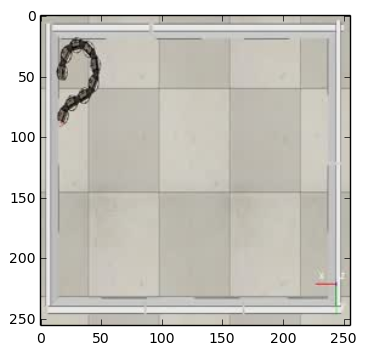

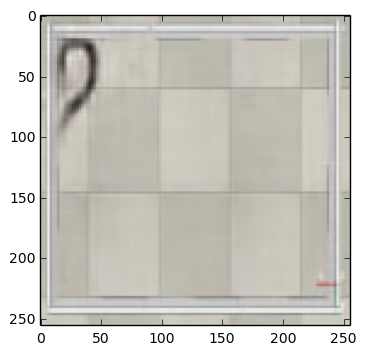

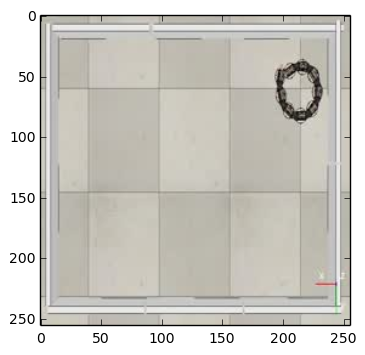

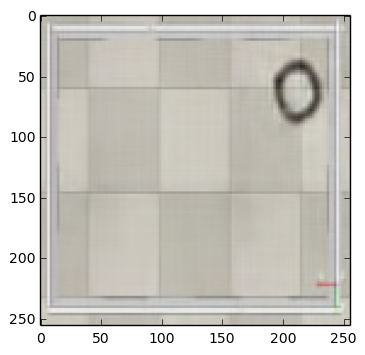

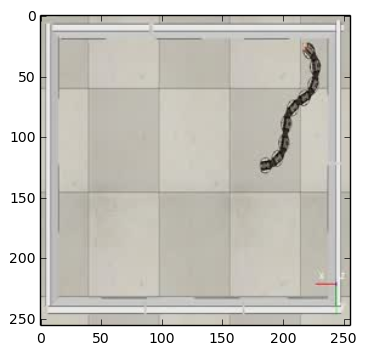

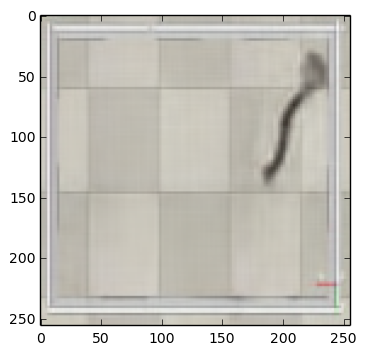

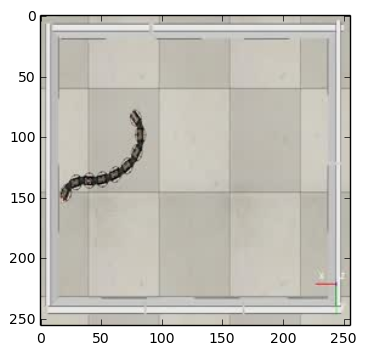

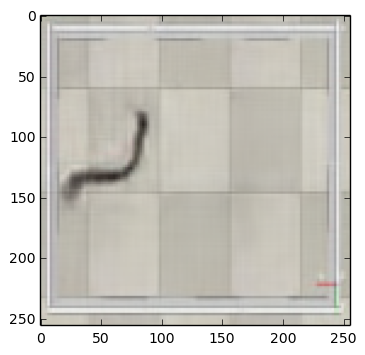

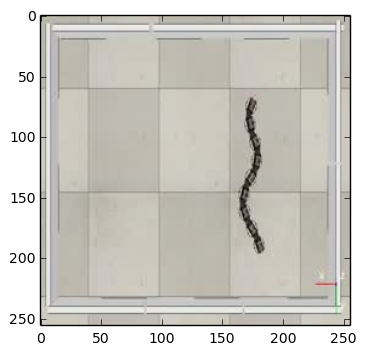

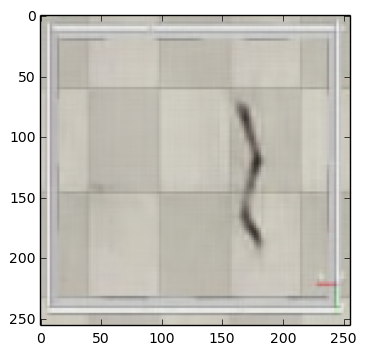

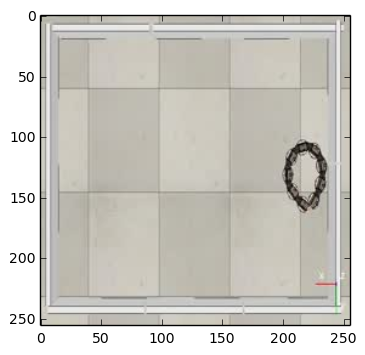

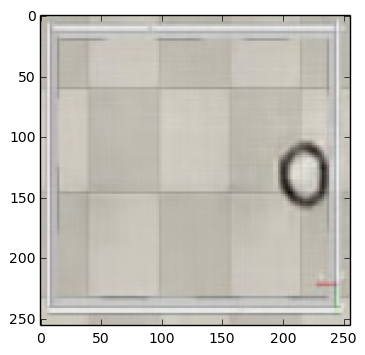

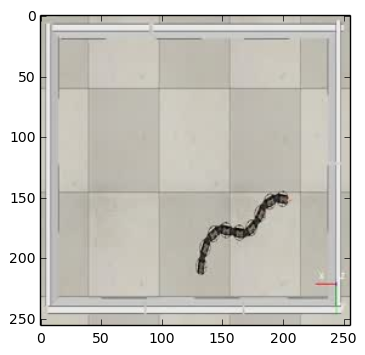

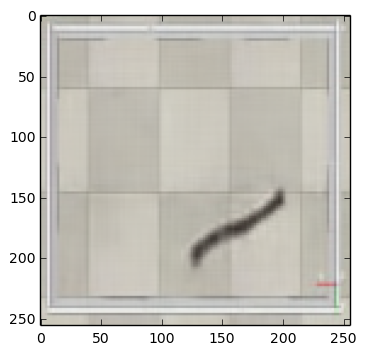

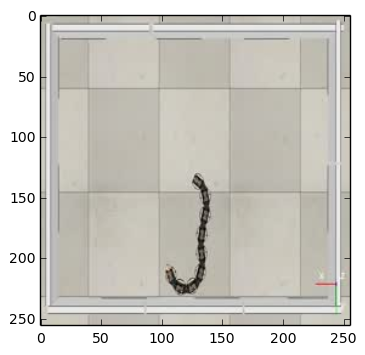

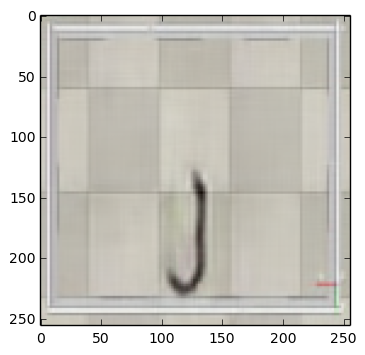

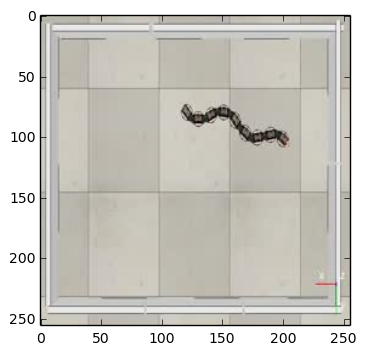

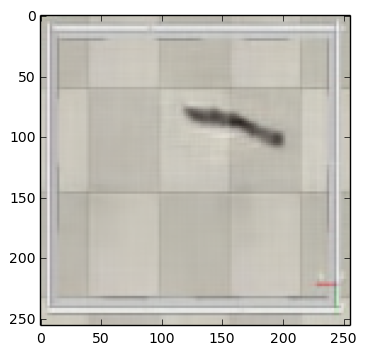

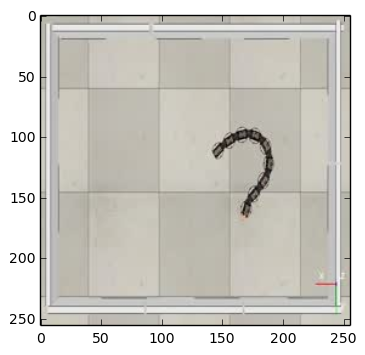

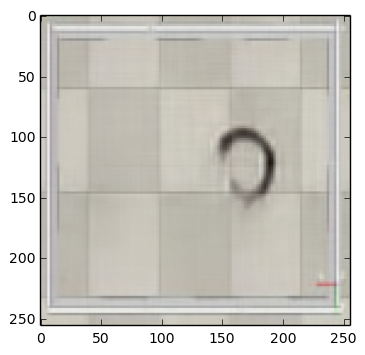

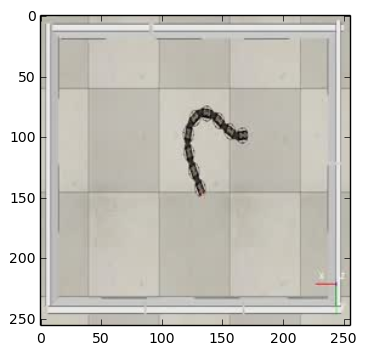

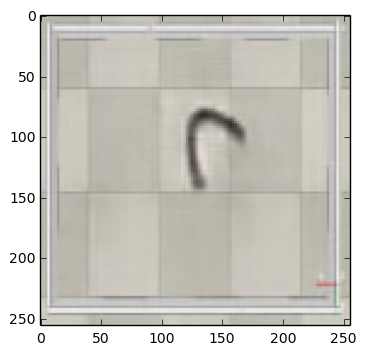

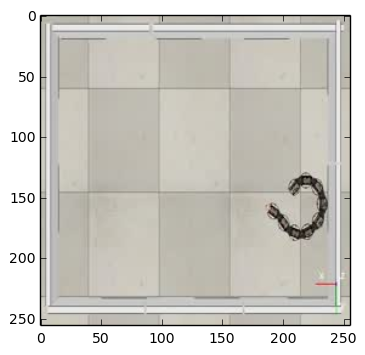

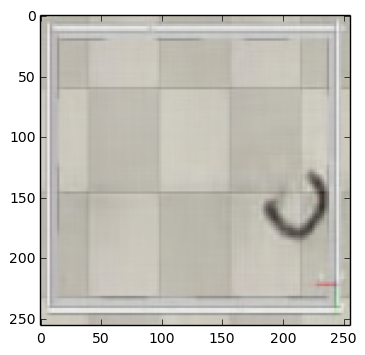

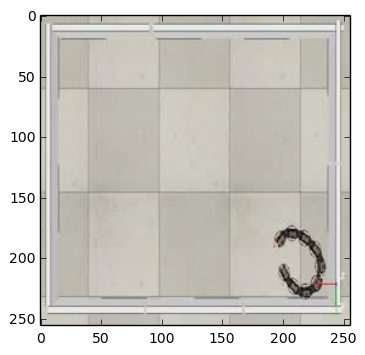

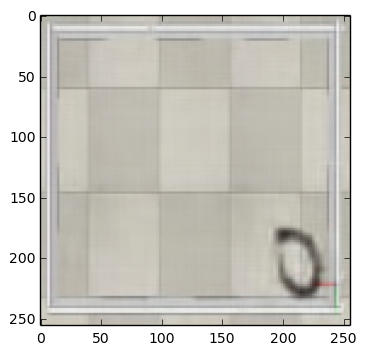

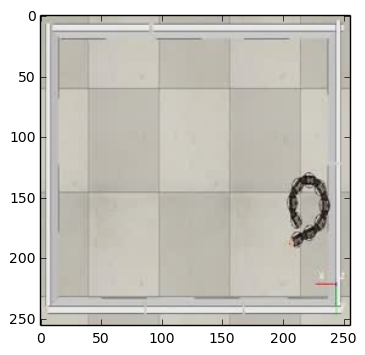

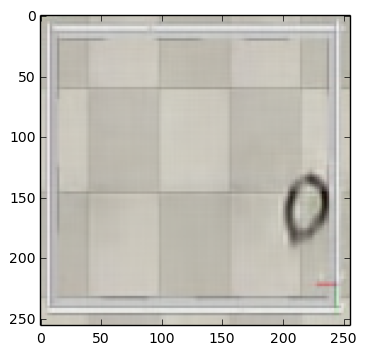

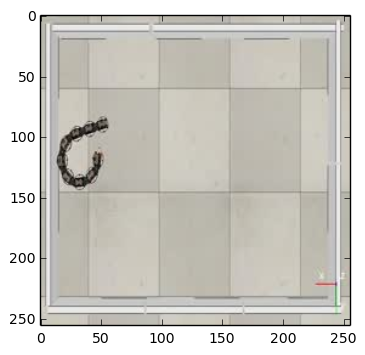

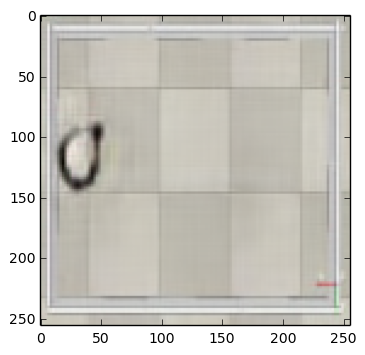

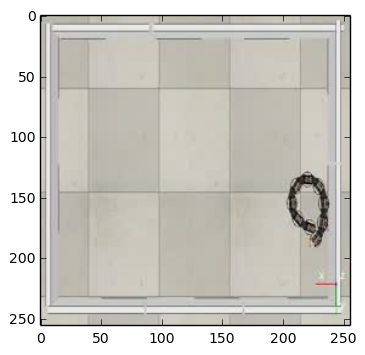

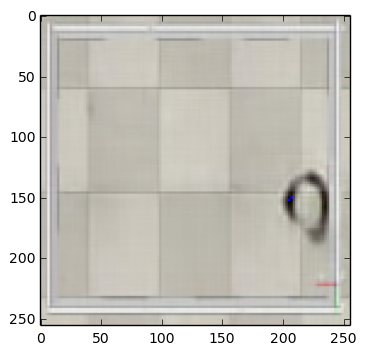

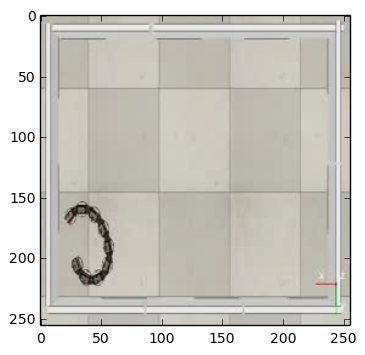

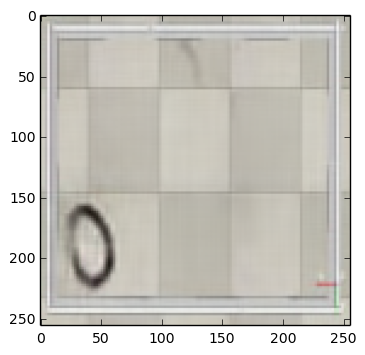

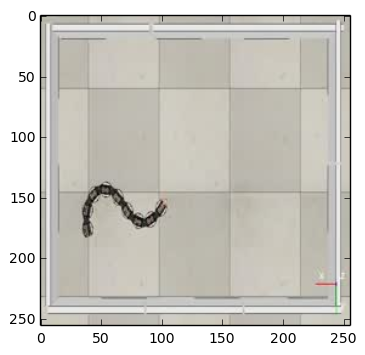

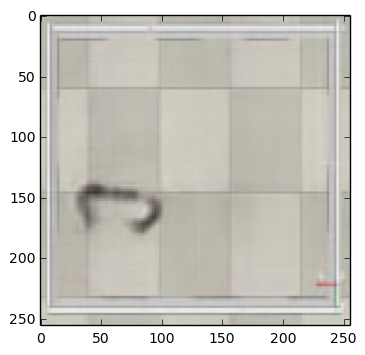

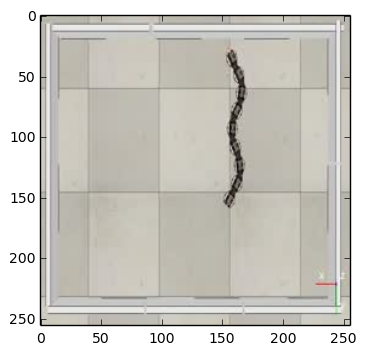

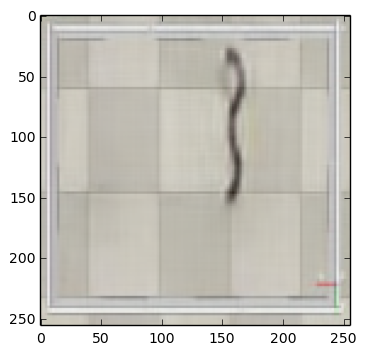

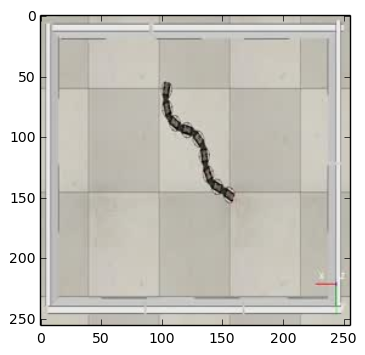

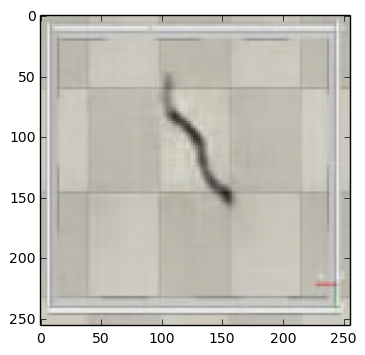

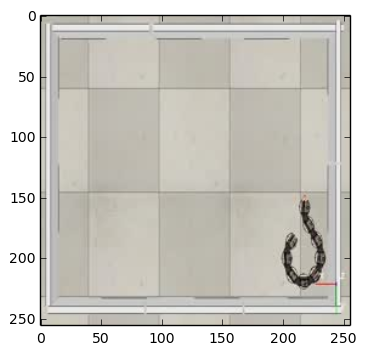

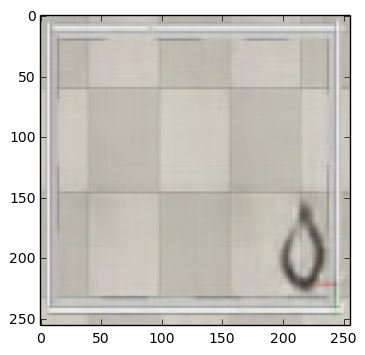

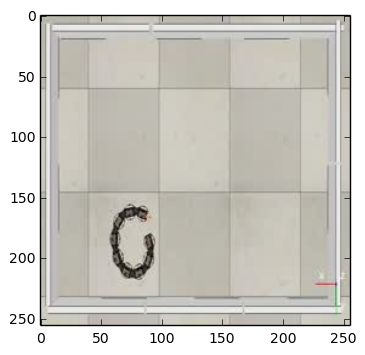

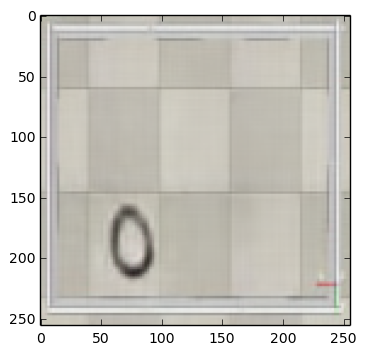

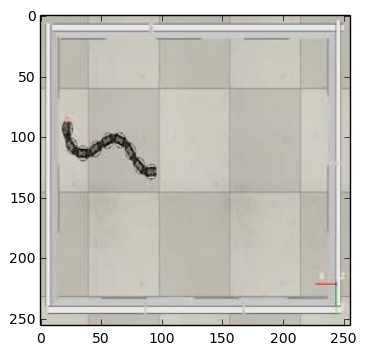

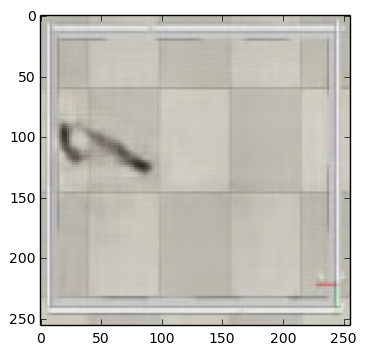

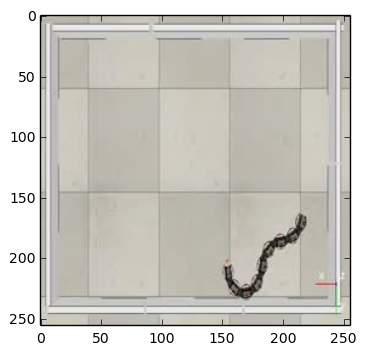

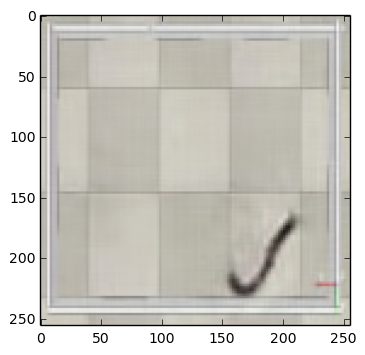

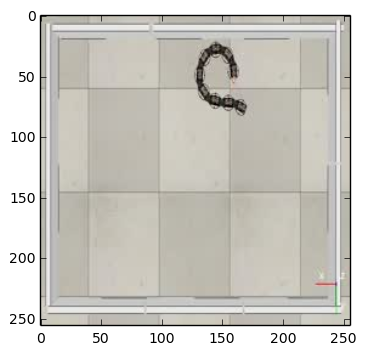

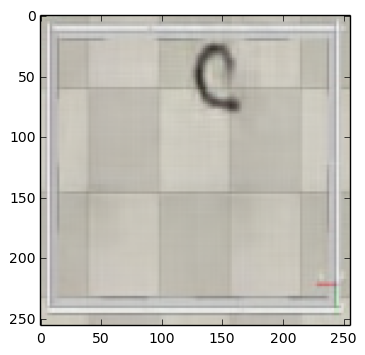

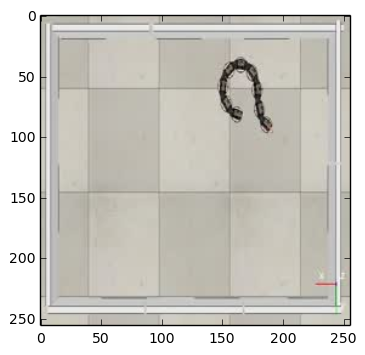

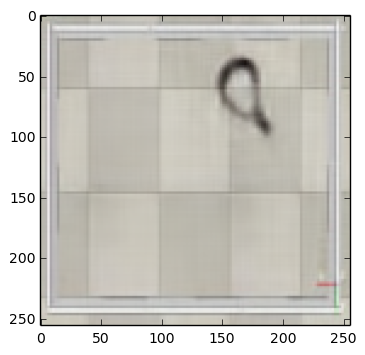

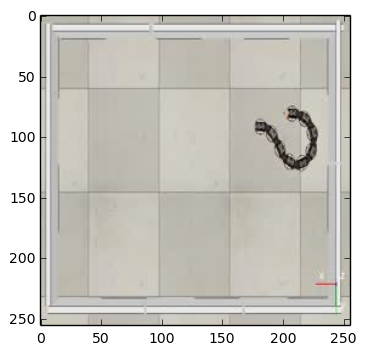

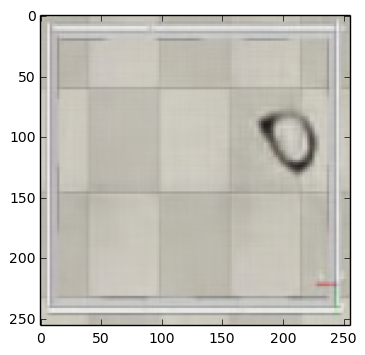

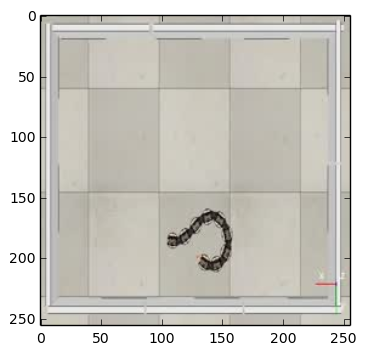

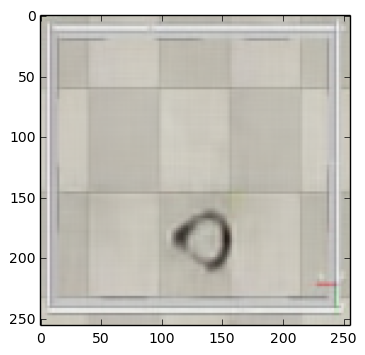

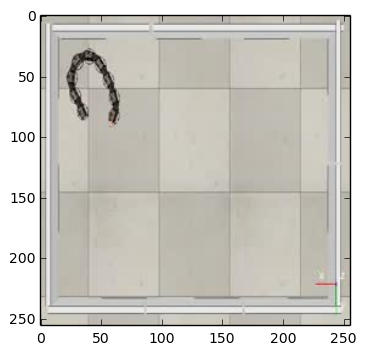

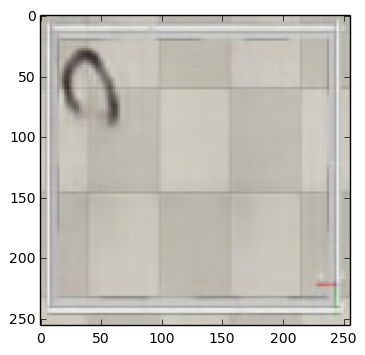

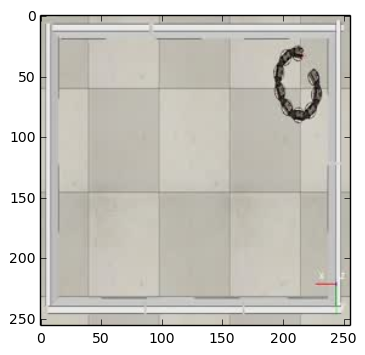

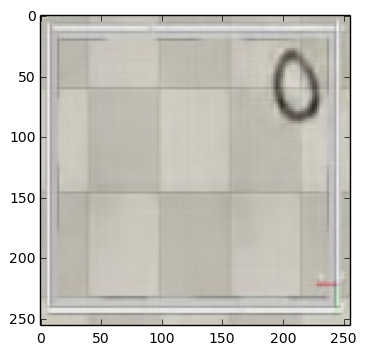

In [8]:
encoded = encoder.predict_on_batch(im_in)
decoded = decoder.predict_on_batch(encoded)
for i in range(batchSz):
    plt.figure()
    plt.imshow(im_in[i,:])
    plt.figure()
    plt.imshow(im_out[i,:])

In [ ]:
from keras.layers import merge, Convolution2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

# first, define the vision modules
digit_input = Input(shape=(1, 25, 25),name="Input1")
x = Convolution2D(64, 3, 3)(digit_input)
x = Convolution2D(64, 3, 3)(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)

vision_model = Model(digit_input, out,name="Vision")

# then define the tell-digits-apart model
digit_a = Input(shape=(1, 27, 27),name="Input2")
digit_b = Input(shape=(1, 27, 27),name="Input3")

# the vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = merge([out_a, out_b], mode='concat')
out = Dense(1, activation='sigmoid')(concatenated)

classification_model = Model([digit_a, digit_b], out)

from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(classification_model).create(prog='dot', format='svg')))

classification_model.summary()

In [ ]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb



numEpochs = 100
numBatchesPerEpoch = 2
nVal = 200

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

def smallTrainGenerator():
    files = os.listdir(trainPath)
    files = files[:numBatchesPerEpoch*batchSz]
    while True:
        res = np.zeros(shape=(batchSz,imDim,imDim,3))
        for i in range(numBatchesPerEpoch):
            for j in range(batchSz):
                res[j,:] = plt.imread(trainPath+files[i*batchSz+j])
            yield (res,res)
        
def smallValGenerator():  
    files = os.listdir(valPath)
    files = files[:nVal]
    res = np.empty(shape=(0,imDim,imDim,3))
    for i in range(nVal):
        im = np.expand_dims(plt.imread(valPath+files[i]),axis=0)
        res = np.concatenate((res,im))
    yield (res,res)
            

# def trainModel(model,trainGenerator,validationGenarator):
#     loss = []
#     validation = []
    
#     Xtrain = np.empty(shape=(0,imDim,imDim, 3))
#     for i in range(numBatchesPerEpoch):
#         train,_ = trainGenerator.next()
#         Xtrain = np.concatenate((Xtrain,train.transpose(0,2,3,1)))
        
#     Xval = np.empty(shape=(0,imDim,imDim,3))
#     for i in range(int(round(nVal/batchSz)):
#         val,_ = validationGenarator.next()
#         Xval = np.concatenate((Xval,val.transpose(0,2,3,1)))
        
#     for i in range(numEpochs):
#         print "Epoch %d of %d" (i+1,numEpochs)
#         for j in tqdm(range(numBatchesPerEpoch)):
#             Xbatch = Xtrain[j*batchSz:(j+1):batchSz,:]
#             loss.append(model.train_on_batch(Xbatch,Xbatch))
#         Xbatch, _ = validation_generator.flow()
#         validation.append(model.test_on_batch(Xval,Xval))
#         print "Epoch %d, loss = %f, val = %f" (i+1,loss[-1],validation[-1])
        
#     return [loss, validation]

In [ ]:
val_data_gen = smallValGenerator()
val_data = val_data_gen.next()

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard

histories = []
lrs = np.sort(10**random.uniform(-1,2,size=10))
for lr in lrs:
    print "Learning rate=" + str(lr)
    print "Compiling model"
    autoencoder.compile(optimizer=Adam(lr=lr),loss='mse')
    print "Done compiling model"
    
    
#     [loss,val] = trainModel(numEpochs=numEpochs,
#                             numBatchesPerEpoch=numBatchesPerEpoch,
#                             nVal=nVal,
#                             model=autoencoder,
#                             trainGenerator=train_generator,
#                             validationGenarator=validation_generator)
    history = autoencoder.fit_generator(generator=smallTrainGenerator(),
                                        samples_per_epoch=numBatchesPerEpoch*batchSz,
                                        nb_epoch=numEpochs,
                                        validation_data=val_data,
                                        callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs')]
                                       )
    histories.append(history)